# What Should I Play?

# Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Load dataframe

In [2]:
ign_games = pd.read_csv('ign.csv', index_col='Unnamed: 0')

In [3]:
ign_games.head(5)

,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12
3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11
4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11


In [4]:
ign_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18625 entries, 0 to 18624
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_phrase    18625 non-null  object 
 1   title           18625 non-null  object 
 2   url             18625 non-null  object 
 3   platform        18625 non-null  object 
 4   score           18625 non-null  float64
 5   genre           18589 non-null  object 
 6   editors_choice  18625 non-null  object 
 7   release_year    18625 non-null  int64  
 8   release_month   18625 non-null  int64  
 9   release_day     18625 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1.6+ MB


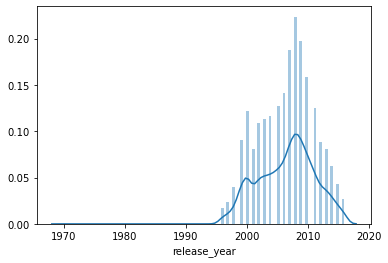

In [5]:
sns.distplot(ign_games['release_year'],bins=100)

# Removing null lines

In [6]:
ign_games.isnull().sum()

score_phrase       0
title              0
url                0
platform           0
score              0
genre             36
editors_choice     0
release_year       0
release_month      0
release_day        0
dtype: int64

In [7]:
ign_games.dropna(inplace=True,)

# Adjusting Index

In [8]:
ign_games.reset_index(inplace=True,drop=True)

# Creating `old school` column

In [9]:
ign_games['old_game']  = ign_games.release_year.apply(lambda x: 1 if x <= 2000 else 0)

# Creating `critic score` column

In [10]:
ign_games['critic_high_score'] = ign_games.score.apply(lambda x: 1 if x >= 8.5 else 0)

# Handling `platforms` columns

## Compiled platform column

In [11]:
ign_games['all_plat'] = None

In [12]:
for index in ign_games.index:
    ign_games.at[index,'all_plat'] = list(ign_games['platform'].loc[ign_games.title == ign_games.title.iloc[index]])

## Generalizing platforms

In [13]:
transf_plat = {key:'' for key in ign_games.platform.unique()}
for key,value in transf_plat.items():
    if key == 'iPhone' or key == 'iPad' or key =='Windows Phone' or key =='Android':
        transf_plat[key] = 'Mobile'
    elif key == 'Linux' or key == 'PC' or key == 'Macintosh' or key == 'Windows Surface' or key == 'Pocket PC' or key == 'SteamOS':
        transf_plat[key] = 'PC'
    elif key == 'PlayStation Vita' or key == 'Nintendo DS' or key == 'Nintendo 3DS' or key == 'New Nintendo 3DS' or key == 'Game Boy Color' or key == 'PlayStation Portable':
        transf_plat[key] = 'Portable'
    elif key == 'Xbox 360' or key == 'PlayStation 3' or key == 'PlayStation 4' or key == 'PlayStation' or key == 'PlayStation 2' or key == 'Wii U' or key == 'Wii' or key == 'Xbox' or key == 'Xbox One':
        transf_plat[key] = key
    elif key == 'Lynx' or key == 'Game.Com' or key == 'Arcade' or key == 'DVD / HD Video Game' or key == 'Wireless' or key == 'iPod' or key == 'Web Games' or key == 'Ouya':
        transf_plat[key] = 'Others'
    else:
        transf_plat[key] = 'Old Consoles'       
ign_games['generic_plat'] = ign_games.platform.map(transf_plat)

## Separating platforms in sectors

In [14]:
playstation = {'PlayStation': 1, 'PlayStation 2': 1, 'PlayStation 3': 1, 'PlayStation 4': 1}
xbox = {'Xbox': 1,'Xbox 360': 1,'Xbox One': 1}
nintento = {'Wii':1, 'Wii U': 1}
portable = {'Portable': 1}
old_console = {'Old Consoles': 1}
mobile = {'Mobile': 1}
pc = {'PC': 1}
others = {'Others': 1}
play4 = {'PlayStation 4': 1}
xone = {'Xbox One': 1}
wiiu = {'Wii U': 2}

ign_games['Sony'] = ign_games.generic_plat.map(playstation)
ign_games['Microsoft'] = ign_games.generic_plat.map(xbox)
ign_games['Nintendo'] = ign_games.generic_plat.map(nintento)
ign_games['Portable'] = ign_games.generic_plat.map(portable)
ign_games['Old_Consoles'] = ign_games.generic_plat.map(old_console)
ign_games['Mobile'] = ign_games.generic_plat.map(mobile)
ign_games['PC'] = ign_games.generic_plat.map(pc)
ign_games['Others_Plat'] = ign_games.generic_plat.map(others)
ign_games['Playstation_4'] = ign_games.generic_plat.map(play4)
ign_games['Xbox_One'] = ign_games.generic_plat.map(xone)
ign_games['Wii_U'] = ign_games.generic_plat.map(wiiu)

In [15]:
ign_games.fillna(value=0,inplace=True)

In [16]:
ign_games[['Sony','Microsoft','Nintendo','Portable','Old_Consoles','Mobile','PC','Others_Plat','Playstation_4','Xbox_One','Wii_U']] = ign_games[['Sony','Microsoft','Nintendo','Portable','Old_Consoles','Mobile','PC','Others_Plat','Playstation_4','Xbox_One','Wii_U']].apply(lambda x: x.astype('int'))

# Spliting genres in columns `genre_1` and `genre_2`

In [17]:
def adj_genre(genre,position):
    try:
        value = genre.split()[position].replace(',','')
        return value
    except:
        return genre

In [18]:
ign_games['genre_1'] = ign_games.genre.apply(lambda x: adj_genre(x,0))
ign_games['genre_2'] = ign_games.genre.apply(lambda x: adj_genre(x,1))

# Creating Genres Dummies Columns

In [19]:
all_genres = list(set(list(ign_games['genre_1'].unique()) + list(ign_games['genre_2'].unique())))
all_genres = np.array(all_genres).reshape(-1, 1)

In [20]:
def my_encoding(df, encoder):
    left = pd.DataFrame(encoder.transform(df.loc[:, ['genre_1']]).toarray(), columns=encoder.categories_[0])
    right = pd.DataFrame(encoder.transform(df.loc[:, ['genre_2']]).toarray(), columns=encoder.categories_[0])
    
    return left + right

In [21]:
encoder = OneHotEncoder()

encoder.fit(all_genres)
my_encoding(ign_games, encoder)

,Action,Adult,Adventure,Baseball,Battle,Board,Card,Casino,Compilation,Editor,...,RPG,Racing,Shooter,Simulation,Sports,Strategy,Trivia,Virtual,Word,Wrestling
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18585,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18587,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
ign_games = pd.concat([ign_games, my_encoding(ign_games, encoder)], axis=1)

# Adjusting `URL` columns

In [23]:
ign_games['url'] = ign_games.url.apply(lambda x: 'https://www.ign.com' + x)

# Adjusting `Date` columns

In [24]:
ign_games['release_date'] = pd.to_datetime(dict(day=ign_games.release_day, month=ign_games.release_month,year=ign_games.release_year)).dt.strftime('%d/%m/%Y')

# Removing unnused columns

In [25]:
ign_games.drop(columns=['genre_1','genre_2','platform','generic_plat','release_year','release_month','release_day'],inplace=True)

In [26]:
ign_games.columns

Index(['score_phrase', 'title', 'url', 'score', 'genre', 'editors_choice',
       'old_game', 'critic_high_score', 'all_plat', 'Sony', 'Microsoft',
       'Nintendo', 'Portable', 'Old_Consoles', 'Mobile', 'PC', 'Others_Plat',
       'Playstation_4', 'Xbox_One', 'Wii_U', 'Action', 'Adult', 'Adventure',
       'Baseball', 'Battle', 'Board', 'Card', 'Casino', 'Compilation',
       'Editor', 'Educational', 'Episodic', 'Fighting', 'First-Person',
       'Flight', 'Golf', 'Hardware', 'Hunting', 'Music', 'Other', 'Party',
       'Pet', 'Pinball', 'Platformer', 'Productivity', 'Puzzle', 'RPG',
       'Racing', 'Shooter', 'Simulation', 'Sports', 'Strategy', 'Trivia',
       'Virtual', 'Word', 'Wrestling', 'release_date'],
      dtype='object')

In [27]:
order_cols = ['title', 'release_date', 'score', 'score_phrase', 'editors_choice','all_plat',
           'genre','url','old_game', 'critic_high_score' ,'Sony', 'Microsoft','Nintendo', 
           'Portable', 'Old_Consoles', 'Mobile', 'PC', 'Others_Plat', 'Playstation_4',
           'Xbox_One','Wii_U','Action', 'Adult','Adventure', 'Baseball', 'Battle', 'Board',
            'Card','Casino', 'Compilation',  'Editor', 'Educational', 'Episodic', 'Fighting',
              'First-Person', 'Flight', 'Golf', 'Hardware', 'Hunting', 'Music', 'Other', 'Party',
              'Pet', 'Pinball',  'Platformer', 'Productivity', 'Puzzle', 'RPG', 'Racing', 'Shooter',
              'Simulation','Sports', 'Strategy', 'Trivia', 'Virtual', 'Word', 'Wrestling']

In [28]:
ign_games = ign_games.reindex(columns=order_cols)

# Adjusting values

In [29]:
def binary_value(value):
    return 0 if value < 1 else 1

In [30]:
data_cols = ['old_game', 'critic_high_score' ,'Sony', 'Microsoft','Nintendo', 
               'Portable', 'Old_Consoles', 'Mobile', 'PC', 'Others_Plat','Playstation_4',
              'Xbox_One','Wii_U', 'Action', 'Adult','Adventure', 'Baseball', 'Battle', 'Board',
              'Card','Casino', 'Compilation','Editor', 'Educational', 'Episodic', 'Fighting', 
              'First-Person', 'Flight','Golf', 'Hardware', 'Hunting', 'Music', 'Other', 'Party', 
              'Pet', 'Pinball', 'Platformer', 'Productivity', 'Puzzle', 'RPG', 'Racing', 'Shooter',
              'Simulation','Sports', 'Strategy', 'Trivia', 'Virtual', 'Word', 'Wrestling']

ign_games[data_cols] = ign_games[data_cols].applymap(binary_value)

# Converting dtype `float` to `int`

In [31]:
ign_games[data_cols] = ign_games[data_cols].apply(lambda x: x.astype('int'))

In [32]:
dummy_ign = ign_games.groupby(by='title',as_index=False).max()

# dummy_ign.info()

In [35]:
dummy_ign.head(5)

,title,release_date,score,score_phrase,editors_choice,all_plat,genre,url,old_game,critic_high_score,...,RPG,Racing,Shooter,Simulation,Sports,Strategy,Trivia,Virtual,Word,Wrestling
0,#IDARB,14/01/2015,7.5,Good,N,[Xbox One],Party,https://www.ign.com/games/it-draws-a-red-box/x...,0,0,...,0,0,0,0,0,0,0,0,0,0
1,'Splosion Man,17/07/2009,9.0,Amazing,Y,[Xbox 360],Action,https://www.ign.com/games/splosion-man/xbox-36...,0,1,...,0,0,0,0,0,0,0,0,0,0
2,.deTuned,16/10/2009,4.0,Bad,N,[PlayStation 3],Other,https://www.ign.com/games/detuned/ps3-14346174,0,0,...,0,0,0,0,0,0,0,0,0,0
3,.hack//G.U. Vol. 1: Rebirth,05/10/2007,5.0,Mediocre,N,[PlayStation 2],RPG,https://www.ign.com/games/hackgu-vol-1-rebirth...,0,0,...,1,0,0,0,0,0,0,0,0,0
4,.hack//G.U. Vol. 2: Reminisce,05/10/2007,5.5,Mediocre,N,[PlayStation 2],RPG,https://www.ign.com/games/hackgu-vol-2-reminis...,0,0,...,1,0,0,0,0,0,0,0,0,0


In [34]:
dummy_ign.to_csv('dummy_ign.csv',sep='|',index=False)